In [1]:
import warnings
warnings.filterwarnings("ignore")

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyfolio

In [2]:
tickers = ['SIE', 'DTE', 'ALV', 'MRK', 'DHL']

In [3]:
# Split the Data into Training and Test set
# Set date variable
start_date = '2010-01-04' # Start date of training set
end_date = '2020-10-08' # End date of training set
test_start_date = '2020-10-09' # End date of test set
test_end_date = '2023-06-30' # End date of test set

# Actual prices and returns

In [4]:
actual = pd.read_csv("prices.csv")

In [5]:
actual.head()

,Date,SIE,DTE,ALV,MRK,DHL
0,2010-01-04,39.892433,4.953136,45.519119,26.576838,13.980
1,2010-01-05,39.916801,4.911083,45.657925,26.381210,14.000
2,2010-01-06,40.063042,4.789590,46.012669,26.364910,14.155
3,2010-01-07,40.538311,4.698472,45.483135,26.919186,14.125
4,2010-01-08,40.794228,4.724171,45.236355,26.646122,14.460


In [6]:
actual.isna().sum()

Date    0
SIE     0
DTE     0
ALV     0
MRK     0
DHL     0
dtype: int64

In [7]:
actual.set_index('Date', inplace=True)
actual

,SIE,DTE,ALV,MRK,DHL
Date,,,,,
2010-01-04,39.892433,4.953136,45.519119,26.576838,13.980
2010-01-05,39.916801,4.911083,45.657925,26.381210,14.000
2010-01-06,40.063042,4.789590,46.012669,26.364910,14.155
2010-01-07,40.538311,4.698472,45.483135,26.919186,14.125
2010-01-08,40.794228,4.724171,45.236355,26.646122,14.460
...,...,...,...,...,...
2023-06-26,155.479996,19.695999,209.199997,152.600006,43.000
2023-06-27,157.559998,19.906000,211.300003,147.199997,43.500
2023-06-28,152.720001,20.030001,211.649994,150.500000,44.305


In [8]:
actual_changes = actual.pct_change()

In [9]:
# Split data set to test set
actual_returns = actual_changes.loc[test_start_date:]

In [10]:
actual_returns

,SIE,DTE,ALV,MRK,DHL
Date,,,,,
2020-10-09,0.006496,-0.003806,0.002743,0.004987,0.007566
2020-10-12,0.007888,0.006599,0.010111,0.000000,0.000485
2020-10-13,-0.010673,0.003106,-0.019548,-0.003435,0.004116
2020-10-14,0.010428,-0.004128,0.003003,-0.016852,0.011575
2020-10-15,-0.027224,-0.031434,-0.028619,-0.035450,-0.029559
...,...,...,...,...,...
2023-06-26,-0.009555,0.007056,0.000239,-0.002288,-0.004399
2023-06-27,0.013378,0.010662,0.010038,-0.035387,0.011628
2023-06-28,-0.030718,0.006229,0.001656,0.022418,0.018506


# 0. Base scenario

In [11]:
# Split data set to training set and test set
train = actual.loc[:end_date] # this is actual prices
test = actual.loc[test_start_date:] # this is actual prices use for mean calculating in optimization

In [12]:
window = 252
start = len(train)-window
actual_test = actual.iloc[start:]
actual_test = actual_test.reset_index(drop=True)

In [13]:
actual_test

,SIE,DTE,ALV,MRK,DHL
0,88.108665,12.722281,172.650269,97.990036,29.719999
1,88.153114,12.755207,170.705826,98.225822,29.760000
2,88.775276,12.941236,173.379425,99.027473,30.315001
3,89.521896,12.929710,173.095856,99.970581,30.395000
4,87.922020,13.040010,174.473190,100.253517,30.520000
...,...,...,...,...,...
942,155.479996,19.695999,209.199997,152.600006,43.000000
943,157.559998,19.906000,211.300003,147.199997,43.500000
944,152.720001,20.030001,211.649994,150.500000,44.305000
945,150.580002,19.930000,211.050003,149.600006,44.195000


## 0.1. Traditional method (lower bound)

Optimization based on the historical prices, 

In [14]:
# working days in a year 252
# Prices (actual) which is used as input to calculate stock covariance
window = 252
start = len(train)-window
data = actual.iloc[start:]
data = data.reset_index(drop=True)

In [15]:
# Perform Maximum the Sharpe ratio optimization model to calculate weights (Durall, 2022)
portfolio_weights_min_var_0 = np.zeros([test.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_min_var_0.shape[0]):    
    select = data.iloc[i:window+i]
    
    mu = expected_returns.mean_historical_return(select)
    S = risk_models.sample_cov(select)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
    
    try:
        weights = ef.max_sharpe()
    except:
        weights = ef.nonconvex_objective(
            objective_functions.sharpe_ratio,
            objective_args=(ef.expected_returns, ef.cov_matrix),
            weights_sum_to_one=True)
    weights = ef.clean_weights(cutoff=0.01, rounding=5)
        
    portfolio_weights_min_var_0[idx] = np.array([weights[j] for j in tickers])
    idx += 1

Text(0.5, 0, 'Time (Years-Months)')

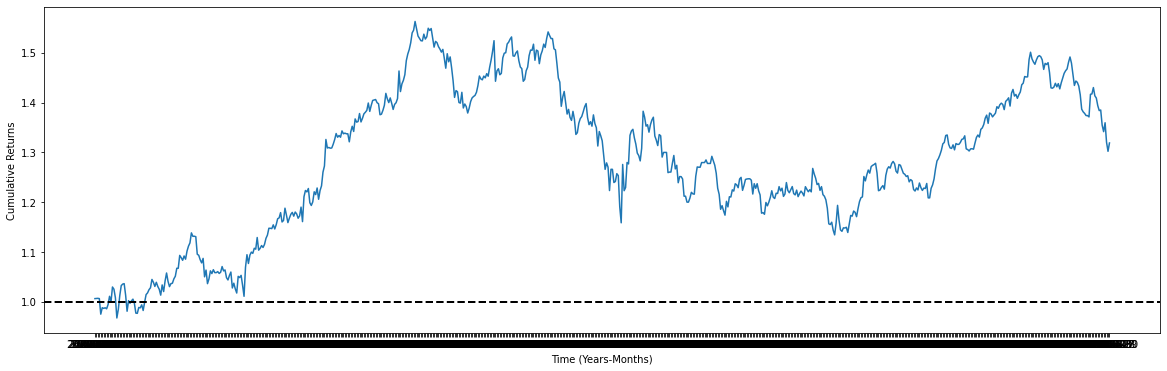

In [16]:
# Calculate porfolio returns from actual returns and resulted weights which is calculated above (Durall, 2022)
return_stocks_min_var_0 = np.sum(actual_returns.multiply(portfolio_weights_min_var_0), axis=1)
cumulative_returns_daily_min_var_0 = (1 + return_stocks_min_var_0).cumprod()
plt.figure(figsize=(20, 6))  # Set the figure size
plt.plot(cumulative_returns_daily_min_var_0)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

In [17]:
# Calculate portfolio variance
portfolio_variance_min_var_0 = np.dot(portfolio_weights_min_var_0[-1].T, np.dot(np.cov(actual_returns, rowvar=False), portfolio_weights_min_var_0[-1]))
portfolio_variance_min_var_0

0.00036146173093508876

In [18]:
# Calculate standard deviation
std_min_var_0 = np.sqrt(portfolio_variance_min_var_0)
std_min_var_0

0.019012146931240793

In [19]:
# Calculate porfolio returns
cumulative_returns_daily_min_var_0[-1]

1.3188908663211754

In [20]:
# Check negative weights
np.any(portfolio_weights_min_var_0 < 0)

False

In [21]:
return_stocks_min_var_0.index = pd.to_datetime(return_stocks_min_var_0.index)

Start date,2020-10-09
End date,2023-06-30
Total months,33
,Backtest
Annual return,10.557%
Cumulative returns,31.889%
Annual volatility,21.389%
Sharpe ratio,0.58
Calmar ratio,0.38
Stability,0.21
Max drawdown,-27.422%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.42,2021-08-20,2022-09-30,NaT,NaN
1,11.19,2021-01-14,2021-03-05,2021-03-30,54
2,6.04,2020-10-27,2020-10-30,2020-11-04,7
3,5.75,2020-11-06,2020-11-19,2020-12-03,20
4,3.16,2020-10-13,2020-10-15,2020-10-23,9


Stress Events,mean,min,max
New Normal,0.05%,-5.35%,10.12%


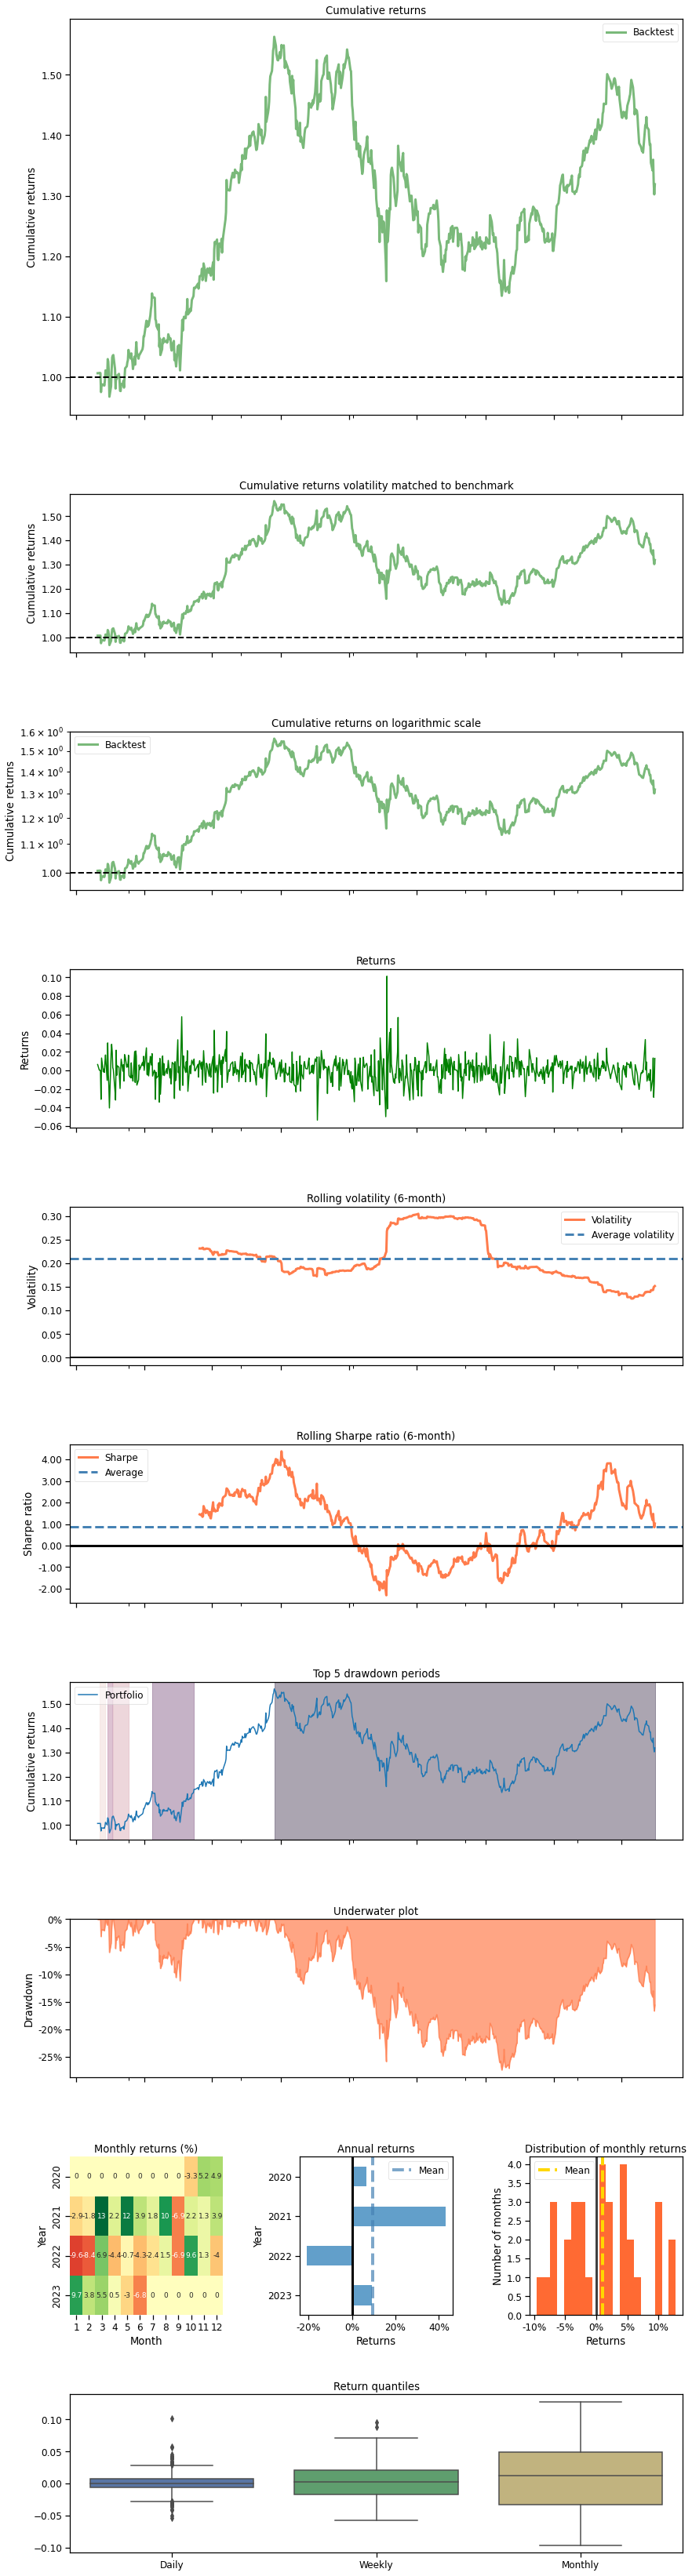

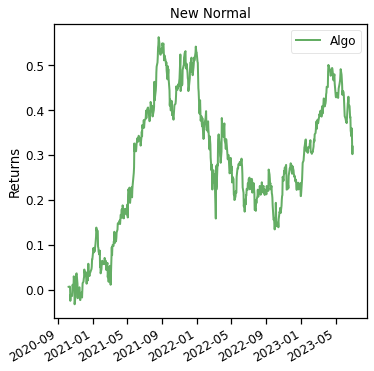

In [22]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_min_var_0, set_context=False)

In [23]:
portfolio_weights_min_var_0

array([[0.     , 0.     , 0.     , 0.48503, 0.51497],
       [0.     , 0.     , 0.     , 0.47225, 0.52775],
       [0.     , 0.     , 0.     , 0.50561, 0.49439],
       ...,
       [0.95027, 0.04973, 0.     , 0.     , 0.     ],
       [0.96821, 0.03179, 0.     , 0.     , 0.     ],
       [0.98787, 0.01213, 0.     , 0.     , 0.     ]])

Text(0.5, 0, 'Time (Years-Months)')

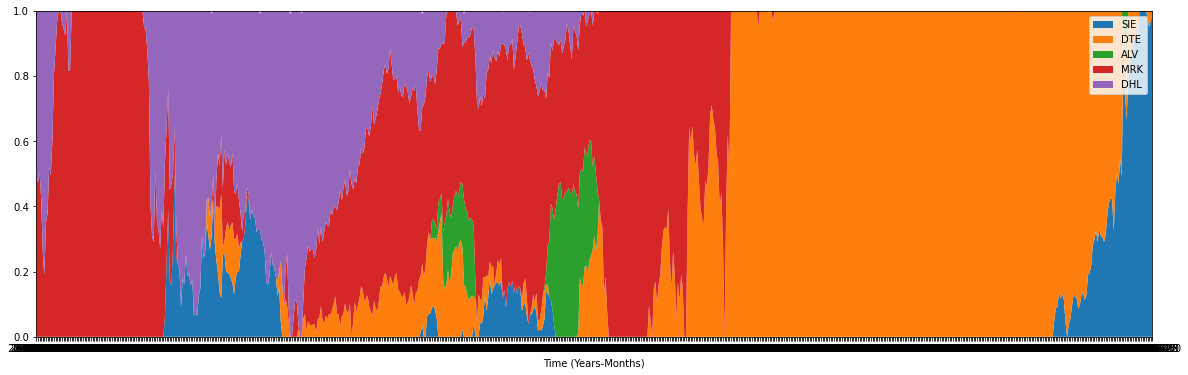

In [24]:
plt.figure(figsize=(20, 6))  # Set the figure size
df_opt_0 = pd.DataFrame (portfolio_weights_min_var_0, index = actual_returns.index, columns = tickers)
plt.stackplot(actual_returns.index, df_opt_0['SIE'], df_opt_0['DTE'], df_opt_0['ALV'], df_opt_0['MRK'], df_opt_0['DHL'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

In [25]:
df_opt_0

,SIE,DTE,ALV,MRK,DHL
Date,,,,,
2020-10-09,0.00000,0.00000,0.0,0.48503,0.51497
2020-10-12,0.00000,0.00000,0.0,0.47225,0.52775
2020-10-13,0.00000,0.00000,0.0,0.50561,0.49439
2020-10-14,0.00000,0.00000,0.0,0.42425,0.57575
2020-10-15,0.00000,0.00000,0.0,0.26081,0.73919
...,...,...,...,...,...
2023-06-26,1.00000,0.00000,0.0,0.00000,0.00000
2023-06-27,0.98051,0.01949,0.0,0.00000,0.00000
2023-06-28,0.95027,0.04973,0.0,0.00000,0.00000


In [26]:
df_opt_0.to_csv('lower_bound.csv', index=True)

## 0.2. Traditional method (upper bound)

Optimization based on the actual prices

In [27]:
# working days in a year 252
# Prices (actual) which is used as input to calculate stock covariance
window = 252
start = len(train)-window
data = actual.iloc[start:]
data = data.reset_index(drop=True)

In [28]:
data

,SIE,DTE,ALV,MRK,DHL
0,88.108665,12.722281,172.650269,97.990036,29.719999
1,88.153114,12.755207,170.705826,98.225822,29.760000
2,88.775276,12.941236,173.379425,99.027473,30.315001
3,89.521896,12.929710,173.095856,99.970581,30.395000
4,87.922020,13.040010,174.473190,100.253517,30.520000
...,...,...,...,...,...
942,155.479996,19.695999,209.199997,152.600006,43.000000
943,157.559998,19.906000,211.300003,147.199997,43.500000
944,152.720001,20.030001,211.649994,150.500000,44.305000
945,150.580002,19.930000,211.050003,149.600006,44.195000


In [29]:
# Perform Maximum the Sharpe ratio optimization model to calculate weights (Durall, 2022)
portfolio_weights_min_var_9 = np.zeros([test.shape[0], len(tickers)])

idx=0
for i in range(portfolio_weights_min_var_9.shape[0]):    
    select = data.iloc[i+1:window+i+1]
    
    mu = expected_returns.mean_historical_return(select)
    S = risk_models.sample_cov(select)

    # optimize for max sharpe ratio
    ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
    
    try:
        weights = ef.max_sharpe()
    except:
        weights = ef.nonconvex_objective(
            objective_functions.sharpe_ratio,
            objective_args=(ef.expected_returns, ef.cov_matrix),
            weights_sum_to_one=True)
    weights = ef.clean_weights(cutoff=0.01, rounding=5)
    
    portfolio_weights_min_var_9[idx]=np.array([weights[j] for j in tickers])
    idx +=1

Text(0.5, 0, 'Time (Years-Months)')

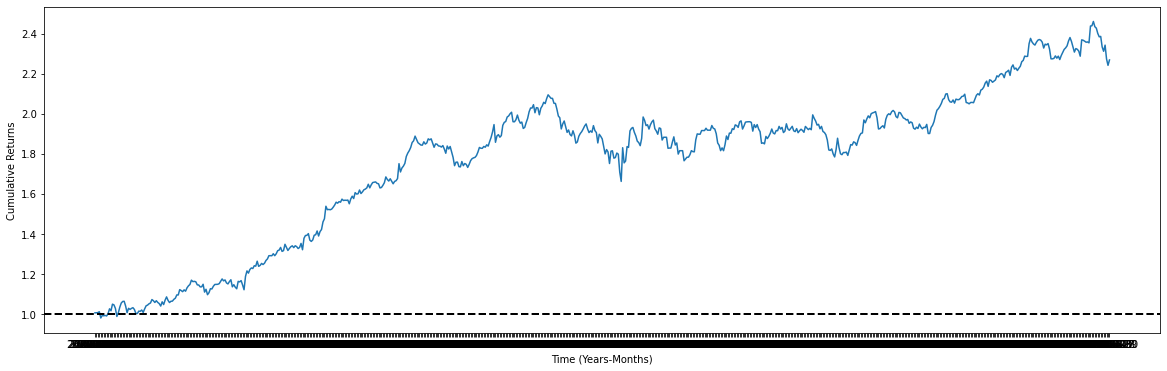

In [30]:
# Calculate porfolio returns from actual returns and resulted weights which is calculated above (Durall, 2022)
return_stocks_min_var_9 = np.sum(actual_returns.multiply(portfolio_weights_min_var_9), axis=1)
cumulative_returns_daily_min_var_9 = (1 + return_stocks_min_var_9).cumprod()
plt.figure(figsize=(20, 6))  # Set the figure size
plt.plot(cumulative_returns_daily_min_var_9)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

In [31]:
# Calculate portfolio variance
portfolio_variance_min_var_9 = np.dot(portfolio_weights_min_var_9[-1].T, np.dot(np.cov(actual_returns, rowvar=False), portfolio_weights_min_var_9[-1]))
portfolio_variance_min_var_9

0.00031817627851168207

In [32]:
# Calculate standard deviation
std_min_var_9 = np.sqrt(portfolio_variance_min_var_9)
std_min_var_9

0.017837496419388067

In [33]:
# Calculate porfolio returns
cumulative_returns_daily_min_var_9[-1]

2.268663951324334

In [34]:
# Check negative weights
np.any(portfolio_weights_min_var_9 < 0)

False

In [35]:
return_stocks_min_var_9.index = pd.to_datetime(return_stocks_min_var_9.index)

Start date,2020-10-09
End date,2023-06-30
Total months,33
,Backtest
Annual return,34.586%
Cumulative returns,126.866%
Annual volatility,21.216%
Sharpe ratio,1.51
Calmar ratio,1.68
Stability,0.78
Max drawdown,-20.636%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,20.64,2021-12-28,2022-03-08,2023-01-16,275
1,8.90,2023-06-15,2023-06-29,NaT,NaN
2,8.27,2021-08-20,2021-10-11,2021-11-03,54
3,6.20,2021-01-14,2021-01-29,2021-02-12,22
4,5.84,2020-10-27,2020-10-30,2020-11-04,7


Stress Events,mean,min,max
New Normal,0.13%,-4.97%,10.12%


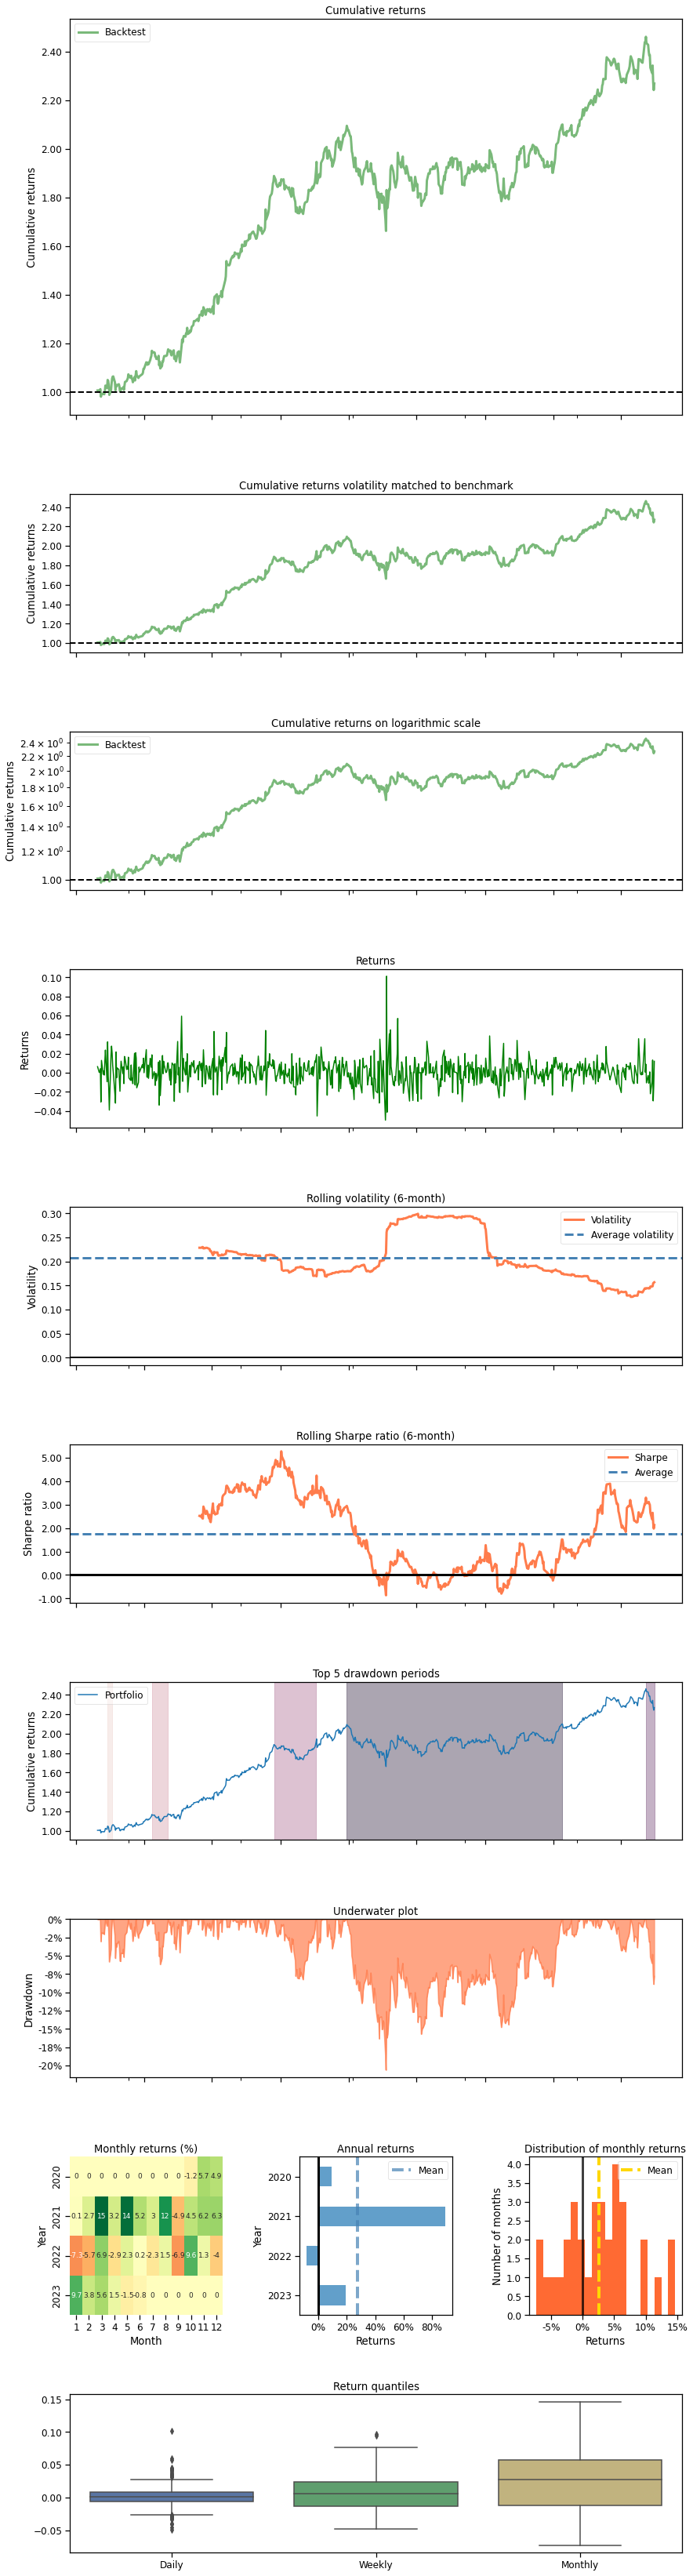

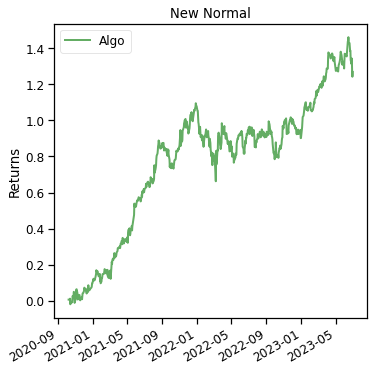

In [36]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_min_var_9, set_context=False)

In [37]:
portfolio_weights_min_var_9

array([[0.     , 0.     , 0.     , 0.47225, 0.52775],
       [0.     , 0.     , 0.     , 0.50561, 0.49439],
       [0.     , 0.     , 0.     , 0.42425, 0.57575],
       ...,
       [0.96821, 0.03179, 0.     , 0.     , 0.     ],
       [0.98787, 0.01213, 0.     , 0.     , 0.     ],
       [0.90185, 0.09815, 0.     , 0.     , 0.     ]])

Text(0.5, 0, 'Time (Years-Months)')

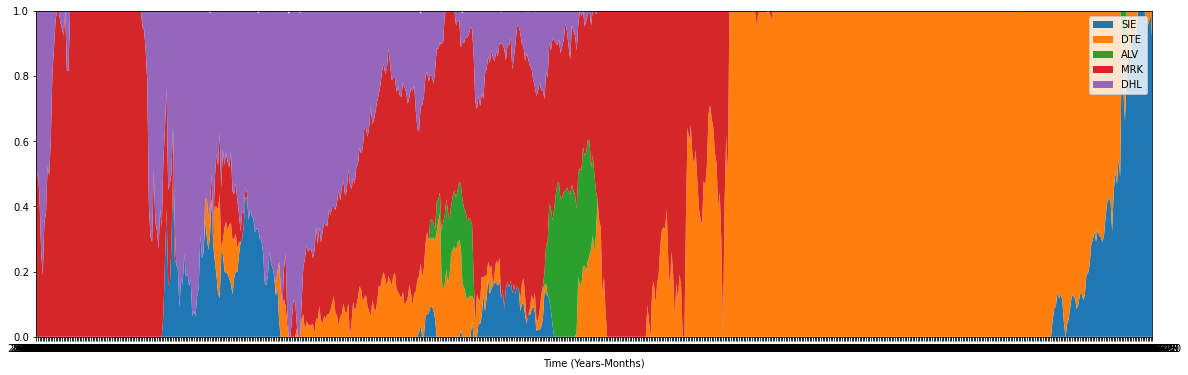

In [38]:
plt.figure(figsize=(20, 6))  # Set the figure size
df_opt_1 = pd.DataFrame (portfolio_weights_min_var_9, index = actual_returns.index, columns = tickers)
plt.stackplot(actual_returns.index, df_opt_1['SIE'], df_opt_1['DTE'], df_opt_1['ALV'], df_opt_1['MRK'], df_opt_1['DHL'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

In [39]:
df_opt_1

,SIE,DTE,ALV,MRK,DHL
Date,,,,,
2020-10-09,0.00000,0.00000,0.0,0.47225,0.52775
2020-10-12,0.00000,0.00000,0.0,0.50561,0.49439
2020-10-13,0.00000,0.00000,0.0,0.42425,0.57575
2020-10-14,0.00000,0.00000,0.0,0.26081,0.73919
2020-10-15,0.00000,0.00000,0.0,0.18822,0.81178
...,...,...,...,...,...
2023-06-26,0.98051,0.01949,0.0,0.00000,0.00000
2023-06-27,0.95027,0.04973,0.0,0.00000,0.00000
2023-06-28,0.96821,0.03179,0.0,0.00000,0.00000


In [40]:
df_opt_1.to_csv('upper_bound.csv', index=True)

## 0.3. Equal weights

In [41]:
portfolio_weights_10 = np.ones([test.shape[0], len(tickers)]) * 0.2

In [42]:
portfolio_weights_10

array([[0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       ...,
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, 0.2, 0.2]])

Text(0.5, 0, 'Time (Years-Months)')

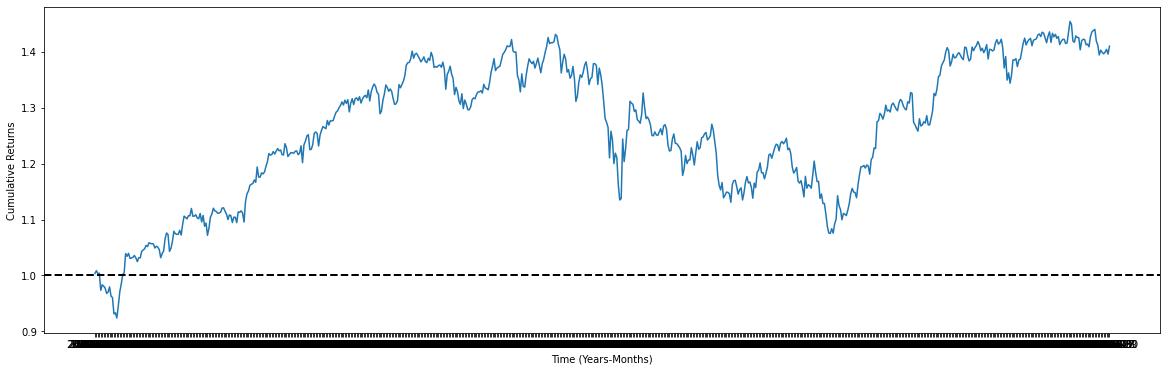

In [43]:
# Calculate porfolio returns from actual returns and resulted weights which is calculated above (Durall, 2022)
return_stocks_10 = np.sum(actual_returns.multiply(portfolio_weights_10), axis=1)
cumulative_returns_daily_10 = (1 + return_stocks_10).cumprod()
plt.figure(figsize=(20, 6))  # Set the figure size
plt.plot(cumulative_returns_daily_10)
plt.axhline(1, color='black', linestyle='--', lw=2)
plt.ylabel("Cumulative Returns")
plt.xlabel("Time (Years-Months)")

In [44]:
# Calculate portfolio variance
portfolio_variance_10 = np.dot(portfolio_weights_10[-1].T, np.dot(np.cov(actual_returns, rowvar=False), portfolio_weights_10[-1]))
portfolio_variance_10

0.00014178414958055765

In [45]:
# Calculate standard deviation
std_10 = np.sqrt(portfolio_variance_10)
std_10

0.011907314961004334

In [46]:
# Calculate porfolio returns
cumulative_returns_daily_10[-1]

1.409962882275935

In [47]:
return_stocks_10.index = pd.to_datetime(return_stocks_10.index)

Start date,2020-10-09
End date,2023-06-30
Total months,33
,Backtest
Annual return,13.266%
Cumulative returns,40.996%
Annual volatility,18.902%
Sharpe ratio,0.75
Calmar ratio,0.53
Stability,0.31
Max drawdown,-24.871%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.87,2022-01-04,2022-09-27,2023-04-19,337
1,8.39,2020-10-12,2020-10-30,2020-11-09,21
2,7.50,2021-08-18,2021-10-12,2021-11-16,65
3,6.58,2021-11-22,2021-11-30,2021-12-28,27
4,4.29,2021-01-14,2021-01-29,2021-02-04,16


Stress Events,mean,min,max
New Normal,0.06%,-4.32%,9.36%


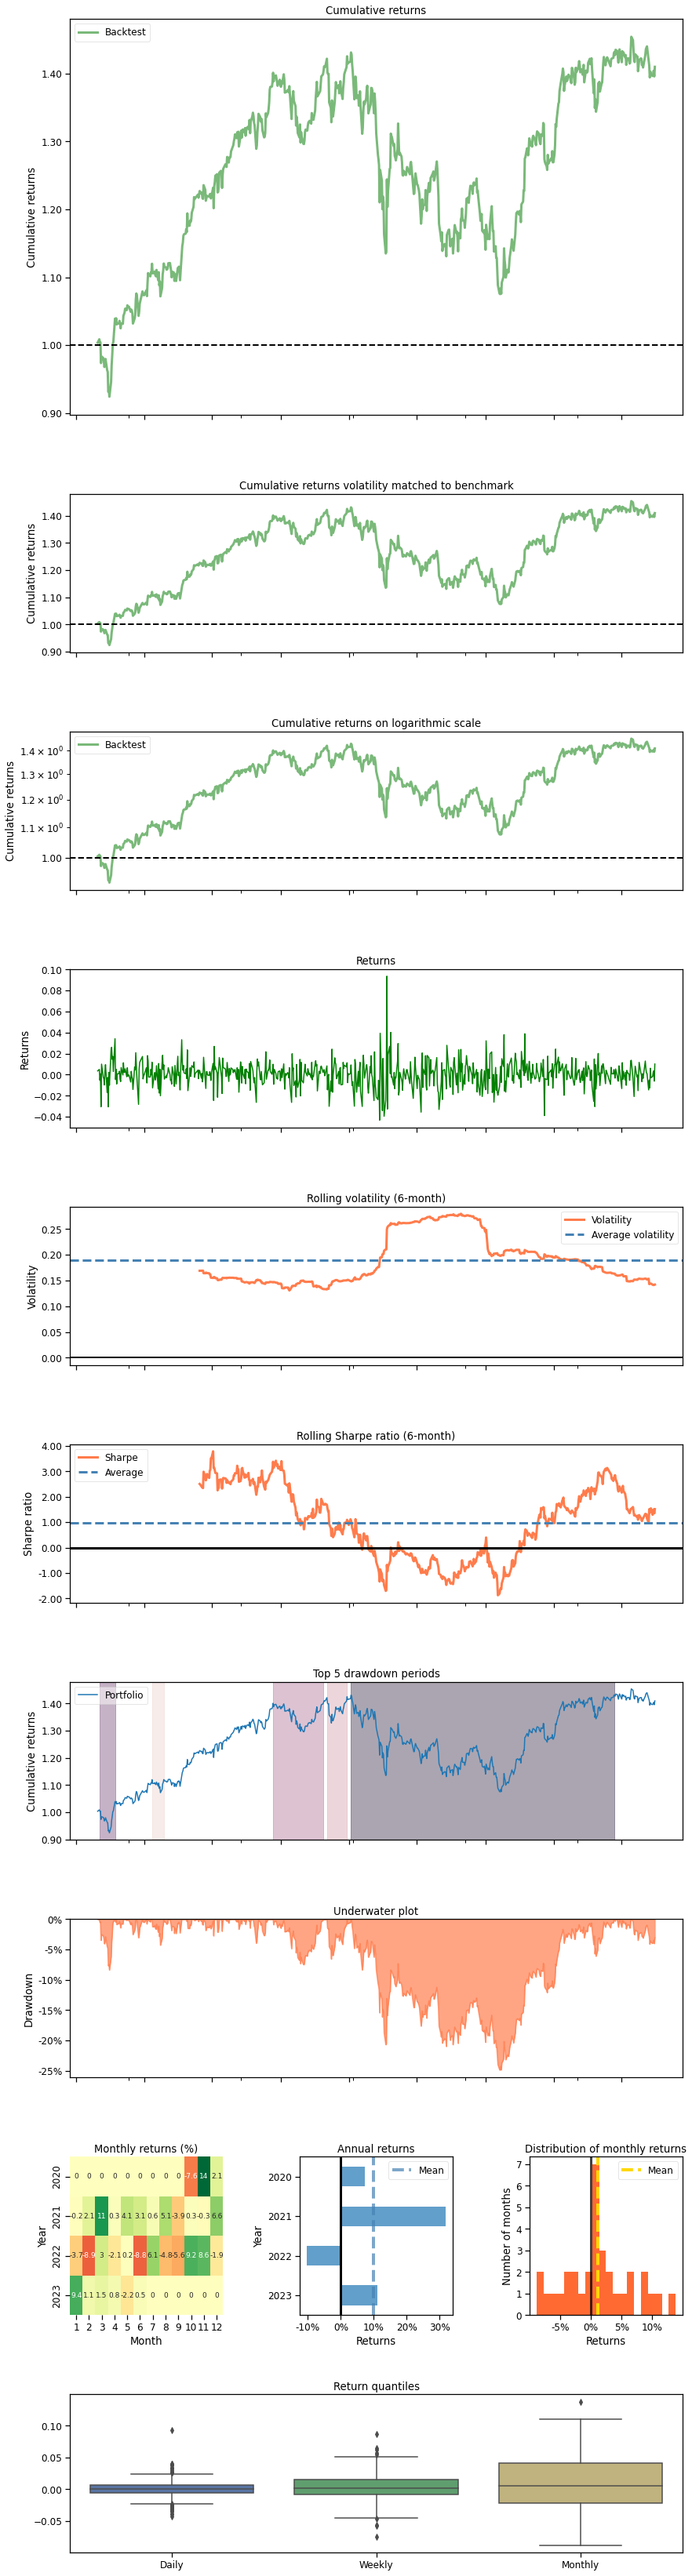

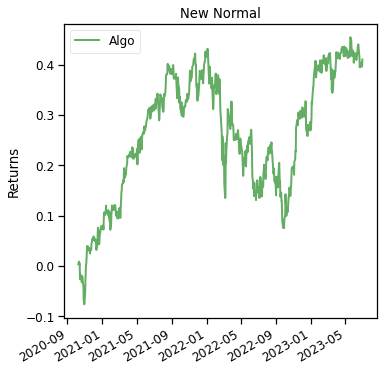

In [48]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = return_stocks_10, set_context=False)

Text(0.5, 0, 'Time (Years-Months)')

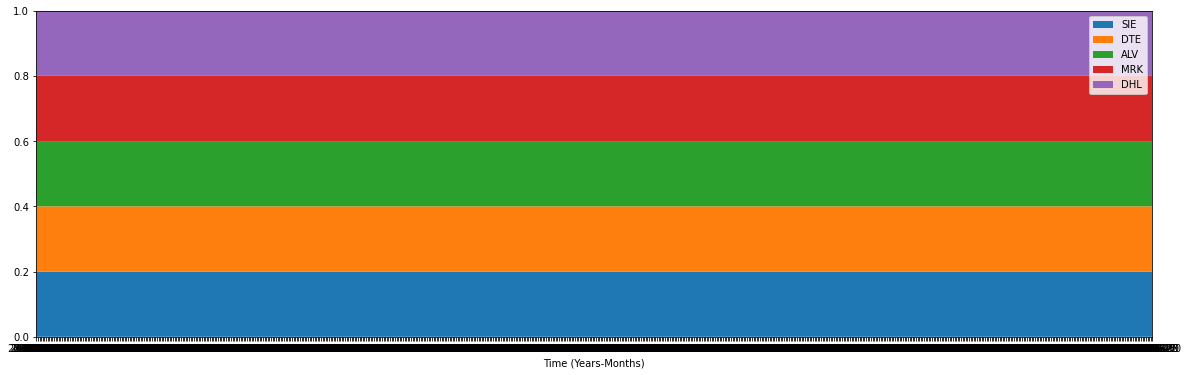

In [49]:
plt.figure(figsize=(20, 6))  # Set the figure size
df_opt_2 = pd.DataFrame (portfolio_weights_10, index = actual_returns.index, columns = tickers)
plt.stackplot(actual_returns.index, df_opt_2['SIE'], df_opt_2['DTE'], df_opt_2['ALV'], df_opt_2['MRK'], df_opt_2['DHL'], labels=tickers)
plt.legend(loc='upper right')
plt.margins(x=0)
plt.margins(y=0)
plt.xlabel("Time (Years-Months)")

In [50]:
df_opt_2

,SIE,DTE,ALV,MRK,DHL
Date,,,,,
2020-10-09,0.2,0.2,0.2,0.2,0.2
2020-10-12,0.2,0.2,0.2,0.2,0.2
2020-10-13,0.2,0.2,0.2,0.2,0.2
2020-10-14,0.2,0.2,0.2,0.2,0.2
2020-10-15,0.2,0.2,0.2,0.2,0.2
...,...,...,...,...,...
2023-06-26,0.2,0.2,0.2,0.2,0.2
2023-06-27,0.2,0.2,0.2,0.2,0.2
2023-06-28,0.2,0.2,0.2,0.2,0.2


In [51]:
df_opt_2.to_csv('equal_weights.csv', index=True)

# Bibliography

- Durall, R. (2022). Asset allocation: From markowitz to deep reinforcement learning. _arXiv preprint arXiv:2208.07158._